## Identify highly variable genes ignoring spatial context and Identify genes differentially expressed between spatial domains with DESeq2

In [1]:
from scGCO import *
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Supple_Fig11a :　compare with DESeq2 and high variable results

In [13]:
result_df= read_result_to_dataframe('../../../results/MouseOB/scGCO_results/Rep11_result_df.csv')

# this is the SV genes identified bu scGCO
fdr_df = result_df[result_df.fdr < 0.05].sort_values(by=['fdr'])
print('Rep11 SV genes identified by scGCO: ',fdr_df.shape)


Rep11 SV genes identified by scGCO:  (333, 269)


In [4]:
deseq2_df=pd.read_csv("../../../data/MOB_DESeq2_results/Rep11_MOB_DESeq2_fc1_df.csv",
                      index_col=0)
print('Rep11 different expression genes calculated by DESeq2:  ', deseq2_df.shape)

Rep11 different expression genes calculated by DESeq2:   (1798, 1)


In [5]:
hvg_df=pd.read_csv("../../../data/HighVariableGenes/Rep11_MOB_hvg.csv",header=None,index_col=0)
print('Rep11 high variable genes:  ', hvg_df.shape)

Rep11 high variable genes:   (2894, 0)


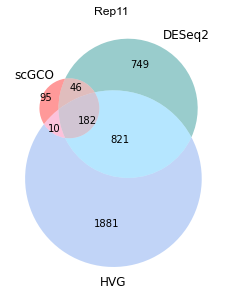

In [6]:

figure, axes = plt.subplots(constrained_layout=True)  

titleText = 'Rep11 '


vn=venn3(subsets=[set(fdr_df.index),
               set(deseq2_df.index.values),
               set(hvg_df.index.values)],
               set_labels = ('scGCO', 'DESeq2',"HVG"), 
                 set_colors=('r','teal','cornflowerblue'),
               ax=axes)
#         lbl_A= vn.get_label_by_id("A")
#         xx, yy = lbl_A.get_position()
#         lbl_A.set_position((xx, yy-0.85)) 

#         lbl_B= vn.get_label_by_id("B")
#         xx, yy = lbl_B.get_position()
#         lbl_B.set_position((xx, yy-0.95)) 

axes.set_title(titleText, fontname="Arial", fontsize=12)
plt.savefig("../../../results/Figure/Supple_Fig11a.pdf",format="pdf",dpi=600)
plt.show()

## Supple_Fig11b

In [7]:
# Compare the Cumulative Distribution Function(cdf) of hamming distance with three SV genes sets 
# 

if True:
    j=11
    unary_scale_factor=100
    label_cost=10
    algorithm='expansion'
    ff = '../../../data/Raw_data/MOB-breast_cancer/Rep' + str(j) +  '_MOB_count_matrix-1.tsv'
    locs,data=read_spatial_expression(ff,sep='\t',num_exp_genes=0.01, num_exp_spots=0.05, min_expression=1)

    data_norm = normalize_count_cellranger(data)
    print('Rep{}_processing: {}'.format(j,data_norm.shape))

    exp=data_norm.iloc[:,1].values
    cellGraph=create_graph_with_weight(locs,exp)

    gmmDict= multiGMM(data_norm)
   
        
    ## upload data
    data_norm_new = pd.read_csv(
        '../../../Temp_files/data_norm_new/Rep'+str(j)+'_data_norm_new.csv',
        index_col=0)
    
    result_df_new = read_result_to_dataframe(
        '../../../results/MouseOB/scGCO_results/Rep'+str(j)+'_result_df.csv')
    result_df = update_result_df_delPoints(result_df_new,data_norm_new,data_norm)
    
    fdr_cut=0.05
    fdr_df=result_df.loc[result_df.fdr< fdr_cut]
    scGCO_list  = fdr_df.index.values
#     print(fdr_df.shape)

    ## DESeq2
    deseq2_list= deseq2_df.index.values
    
    ## HVGs
    hvg_list= hvg_df.index.values

    common = list(set(result_df.index) & (set(scGCO_list) & set(deseq2_list) & set(hvg_list)))
    scGCO_only = list(set(result_df.index) & (set(scGCO_list)- set(common)-set(deseq2_list)-set(hvg_list)))
    DESeq2_only = list(set(result_df.index) & (set(deseq2_list)-set(common)-set(scGCO_list)-set(hvg_list)))
    HVG_only=list(set(result_df.index) & (set(hvg_list)-set(common)-set(scGCO_list)-set(deseq2_list)))
    List_df=['scGCO_only','DESeq2_only','HVG_only','common']

    # ## get tissue mat
    
    with open('../../../Temp_files/tissue_mat/Rep'+str(j)+'_tissue_mat_sorted.plk','rb') as f:
        tissue_mat_sorted = pickle.load(f)
    

    ### compare tissue_mat for getting hamming, Jaccard and Hausdorff df  
    for listName in List_df:
        geneList=eval(listName)
        calc_df= result_df.loc[geneList,]
        print(listName, calc_df.shape)
        dist_df,_ = calc_distance_df(locs, data_norm, cellGraph,
                                        gmmDict, calc_df , tissue_mat_sorted, sort_tissue=True)
        dist_df.to_csv(
            '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,listName))

raw data dim: (262, 16218)
Rep11_processing: (259, 12522)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:59<00:00,  7.40s/it]


del_points_number:  6
scGCO_only (95, 263)
DESeq2_only (749, 263)
HVG_only (1607, 263)
common (182, 263)


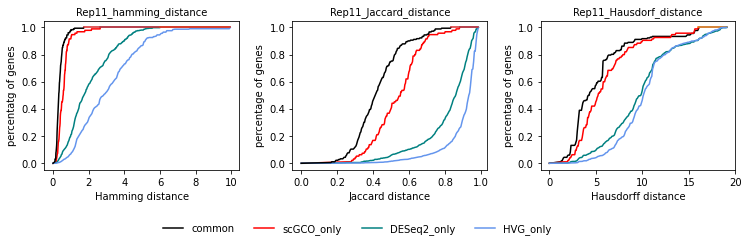

In [8]:
List_df=['scGCO_only','DESeq2_only','HVG_only','common']

nrows=1
ncols=3
fig,ax = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*3))

 
j=11
scgco_dist =pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,List_df[0]))
deseq2_dist =pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,List_df[1])) 
hvg_dist = pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,List_df[2]))
common_dist =pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,List_df[3]))

cdf_scgco=cumcdf(scgco_dist.Hamming.values,num_bin=200)
cdf_deseq2=cumcdf(deseq2_dist.Hamming.values,num_bin=200)
cdf_hvg=cumcdf(hvg_dist.Hamming.values,num_bin=200)
cdf_co=cumcdf(common_dist.Hamming.values,num_bin=200)
max_x= max(cdf_scgco[0][-1], cdf_deseq2[0][-1], cdf_hvg[0][-1], cdf_co[0][-1])
max_y= max(cdf_scgco[1][-1], cdf_deseq2[1][-1], cdf_hvg[1][-1], cdf_co[1][-1])

ax[0].plot(np.append(0,cdf_scgco[0]),np.append(0, cdf_scgco[1]),c='r',label=List_df[0])
ax[0].plot(np.append(cdf_scgco[0][-1], max_x), np.append(cdf_scgco[1][-1], max_y))

ax[0].plot(np.append(0,cdf_deseq2[0]),np.append(0, cdf_deseq2[1]),c='teal',label=List_df[1]) 
ax[0].plot(np.append(cdf_deseq2[0][-1], max_x), np.append(cdf_deseq2[1][-1], max_y))

ax[0].plot(np.append(0,cdf_hvg[0]),np.append(0, cdf_hvg[1]),c='cornflowerblue',label=List_df[2])
ax[0].plot(np.append(cdf_hvg[0][-1], max_x), np.append(cdf_hvg[1][-1], max_y))     

ax[0].plot(np.append(0,cdf_co[0]),np.append(0, cdf_co[1]),c='k',label=List_df[3])   
ax[0].plot(np.append(cdf_co[0][-1], max_x), np.append(cdf_co[1][-1], max_y))
ax[0].set_title('Rep{}_hamming_distance'.format(j), fontsize=10)
ax[0].set_xlabel('Hamming distance')#,fontsize=15)
ax[0].set_ylabel('percentatg of genes')#,fontsize=15)



cdf_scgco=cumcdf(scgco_dist.Jaccard.values,num_bin=200)
cdf_deseq2=cumcdf(deseq2_dist.Jaccard.values,num_bin=200)
cdf_hvg=cumcdf(hvg_dist.Jaccard.values,num_bin=200)
cdf_co=cumcdf(common_dist.Jaccard.values,num_bin=200)

max_x= max(cdf_scgco[0][-1], cdf_deseq2[0][-1], cdf_hvg[0][-1], cdf_co[0][-1])
max_y= max(cdf_scgco[1][-1], cdf_deseq2[1][-1], cdf_hvg[1][-1], cdf_co[1][-1])

ax[1].plot(np.append(0,cdf_scgco[0]),np.append(0, cdf_scgco[1]),c='r',label=List_df[0])
ax[1].plot(np.append(cdf_scgco[0][-1], max_x), np.append(cdf_scgco[1][-1], max_y))

ax[1].plot(np.append(0,cdf_deseq2[0]),np.append(0, cdf_deseq2[1]),c='teal',label=List_df[1])
ax[1].plot(np.append(cdf_deseq2[0][-1], max_x), np.append(cdf_deseq2[1][-1], max_y))

ax[1].plot(np.append(0,cdf_hvg[0]),np.append(0, cdf_hvg[1]),c='cornflowerblue',label=List_df[2])
ax[1].plot(np.append(cdf_hvg[0][-1], max_x), np.append(cdf_hvg[1][-1], max_y))

ax[1].plot(np.append(0,cdf_co[0]),np.append(0, cdf_co[1]),c='k',label=List_df[3])
ax[1].plot(np.append(cdf_co[0][-1], max_x), np.append(cdf_co[1][-1], max_y))


ax[1].set_title('Rep{}_Jaccard_distance'.format(j))

ax[1].set_xlabel('Jaccard distance')
ax[1].set_ylabel('percentage of genes')
#     ax.axvline(cutoff_ja,ls='--',c='grey')

ax[1].set_title('Rep'+str(j)+'_Jaccard_distance',fontsize=10)



cdf_scgco=cumcdf(scgco_dist.Hausdorff.values,num_bin=200)
cdf_deseq2=cumcdf(deseq2_dist.Hausdorff.values,num_bin=200)
cdf_hvg=cumcdf(hvg_dist.Hausdorff.values,num_bin=200)
cdf_co=cumcdf(common_dist.Hausdorff.values,num_bin=200)

max_x= max(cdf_scgco[0][-1], cdf_deseq2[0][-1], cdf_hvg[0][-1], cdf_co[0][-1])
max_y= max(cdf_scgco[1][-1], cdf_deseq2[1][-1], cdf_hvg[1][-1], cdf_co[1][-1])

ax[2].plot(np.append(0,cdf_co[0]),np.append(0, cdf_co[1]),c='k',label=List_df[3])
ax[2].plot(np.append(cdf_co[0][-1], max_x), np.append(cdf_co[1][-1], max_y))

ax[2].plot(np.append(0,cdf_scgco[0]),np.append(0, cdf_scgco[1]),c='r',label=List_df[0])
ax[2].plot(np.append(cdf_scgco[0][-1], max_x), np.append(cdf_scgco[1][-1], max_y))

ax[2].plot(np.append(0,cdf_deseq2[0]),np.append(0, cdf_deseq2[1]),c='teal',label=List_df[1])
ax[2].plot(np.append(cdf_deseq2[0][-1], max_x), np.append(cdf_deseq2[1][-1], max_y))

ax[2].plot(np.append(0,cdf_hvg[0]),np.append(0, cdf_hvg[1]),c='cornflowerblue',label=List_df[2])
ax[2].plot(np.append(cdf_hvg[0][-1], max_x), np.append(cdf_hvg[1][-1], max_y))



ax[2].set_title('Rep{}_Hausdorff_distance'.format(j))

ax[2].set_xlabel('Hausdorff distance')
ax[2].set_ylabel('percentage of genes')
#     ax.axvline(cutoff_ja,ls='--',c='grey')

ax[2].set_title('Rep'+str(j)+'_Hausdorf_distance',fontsize=10)

# ax[1].
plt.tight_layout()
plt.legend(frameon=False, ncol=4, bbox_to_anchor=(0.1, -0.3))
plt.savefig('../../../results/Figure/Supple_Fig11b.pdf')
plt.show()

## Supple_Fig11c-d

In [14]:
sample_info=pd.read_csv("../../../data/MOB_DESeq2_results/Rep11_labels_df.csv",index_col=0)

In [15]:
data_norm = pd.read_csv('../../../Temp_files/data_norm_new/Rep11_data_norm_new.csv',
                       index_col=0)

data_norm.loc[:,"cluster"]=sample_info.cluster

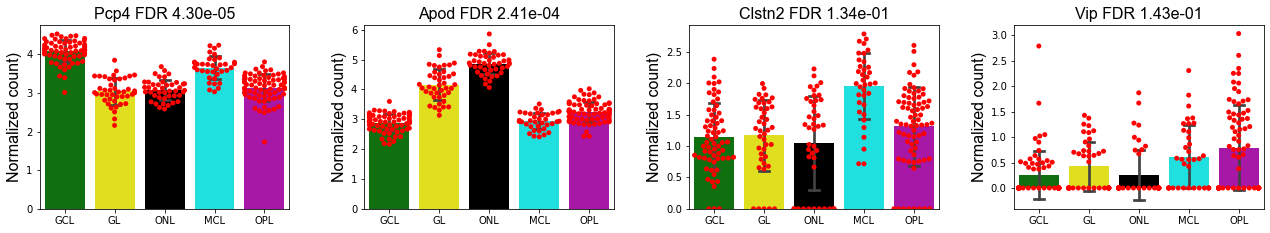

In [16]:
plot_genes=["Pcp4","Apod","Clstn2","Vip"]

fig,axes=plt.subplots(1,4,figsize=(20,3))
fig.subplots_adjust( wspace=0.3, #hspace=0.3,
                                top=0.925, right=0.925, bottom=0.075, left = 0.075)
for i, geneID in enumerate(plot_genes):
#     x = int(i/4)
    y= (i) % 4
    ax=axes[y]
    palette=["green","yellow","k","cyan","m"]
    sns.barplot(x="cluster",y=geneID,data=data_norm,ci="sd",palette=palette,capsize=.2,ax=ax)
    sns.swarmplot(x="cluster",y=geneID,data=data_norm,ax=ax,color="r")
    ax.set_xticklabels(["GCL","GL","ONL","MCL","OPL"])
    ax.set_xlabel("")
    ax.set_ylabel("Normalized count)",fontname="Arial",fontsize=16)
    ax.set_title(geneID+ " FDR {:.2e}".format(result_df.loc[geneID,"fdr"]),fontname="Arial",fontsize=16)
fig.savefig("../../../results/Figure/Supple_Fig11c-d.pdf",format="pdf",dpi=300)

## Supple_Fig11e-f

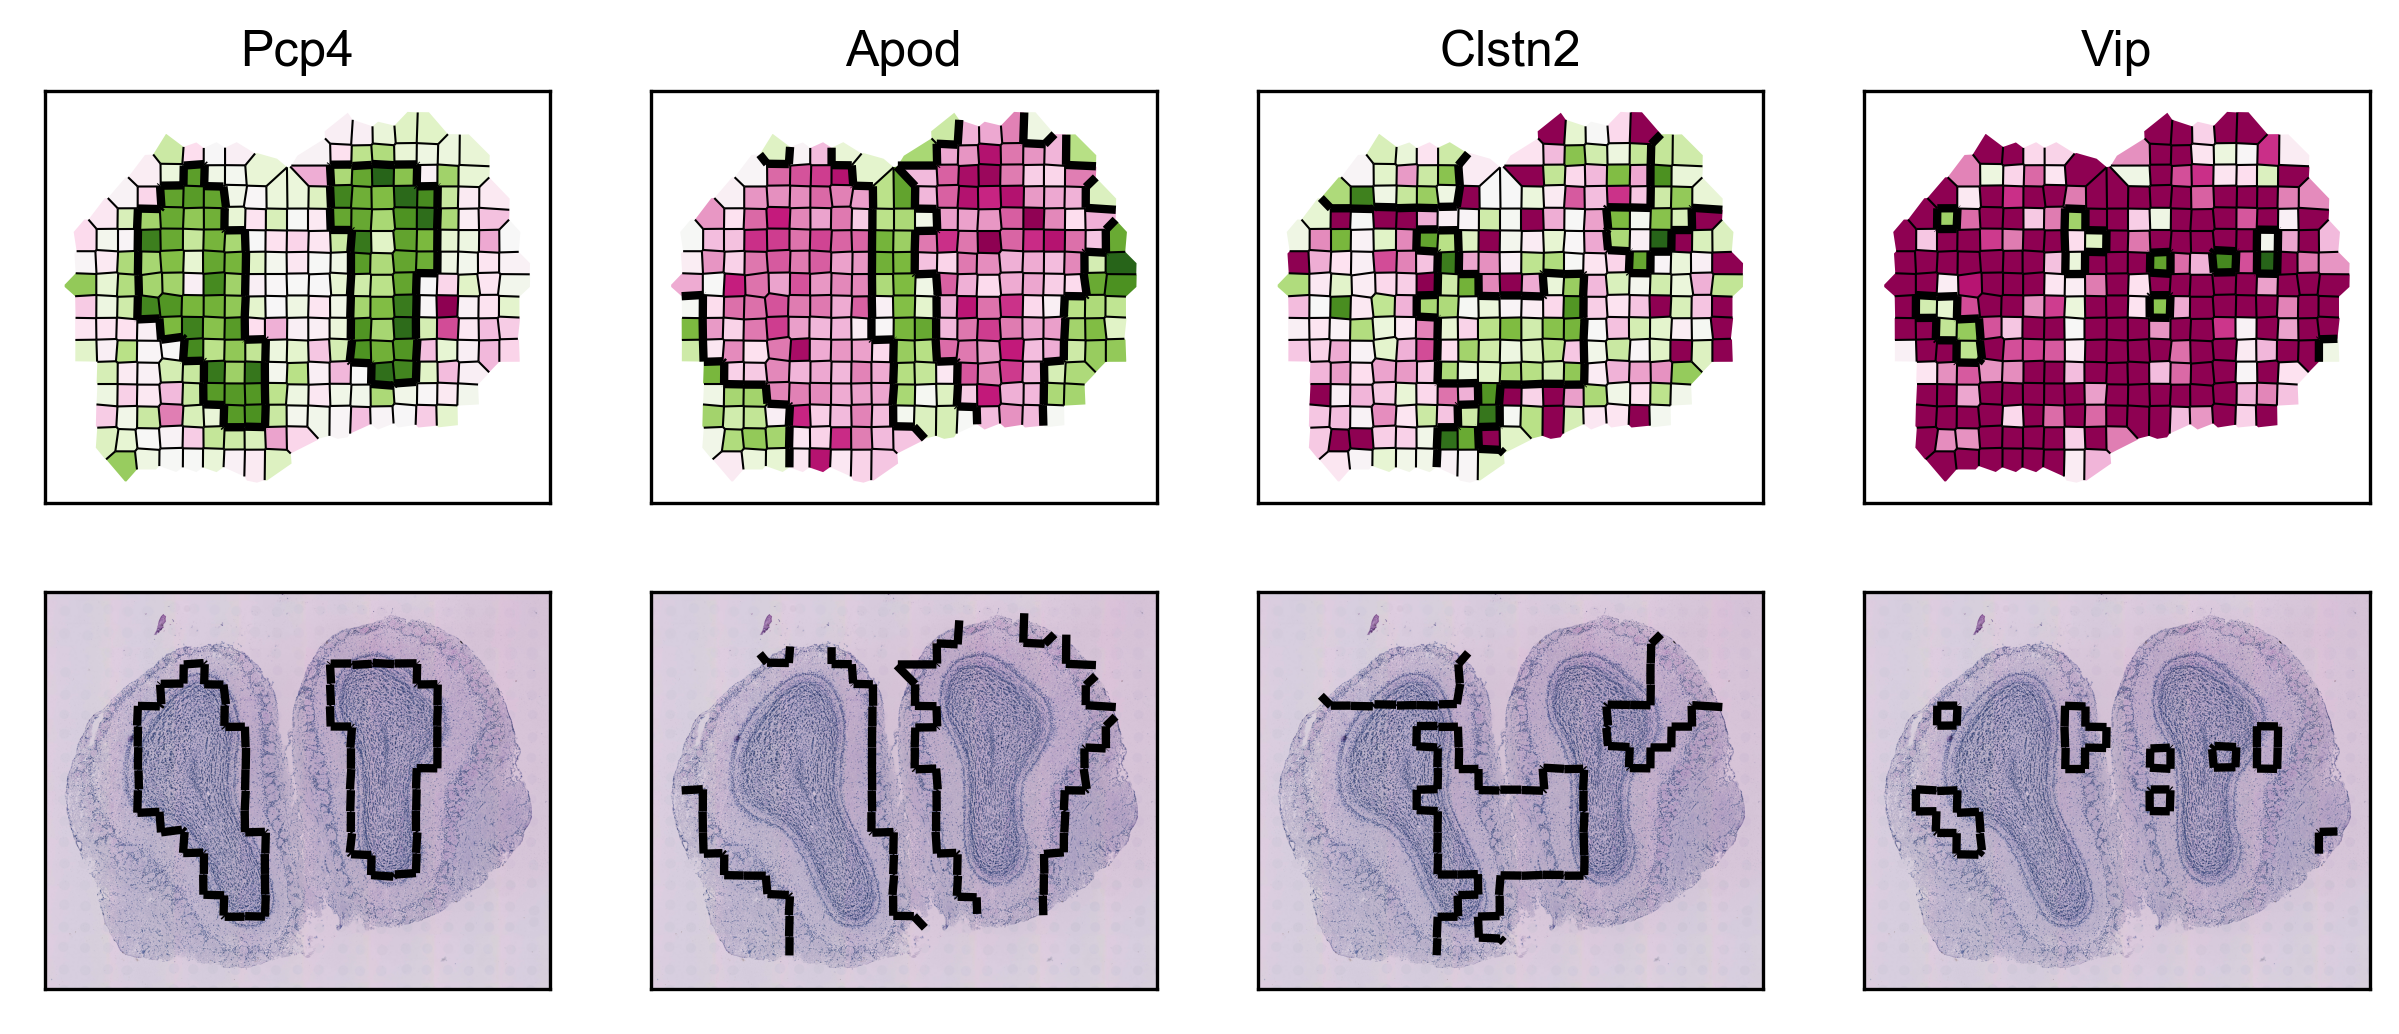

In [17]:
plot_genes=["Pcp4","Apod","Clstn2","Vip"]
fig,ax=plt.subplots(2,4,dpi=300,figsize=(10,4))
locs = Get_coord(data_norm)
for i ,geneID in enumerate(plot_genes):

    y= (i) % 4
    exp =  data_norm.loc[:,geneID]
    cellGraph = create_graph_with_weight(locs, exp)

    newLabels = result_df.loc[geneID][4:]
    p=result_df.loc[geneID,"p_value"]

    axes=ax[0][y]
    subplot_voronoi_boundary(geneID,locs,exp,newLabels,min(p),axes,class_line_width=2,point_size=0)
    axes.set_title(geneID, fontname="Arial", fontsize=12)
    axes.set_xticks([])
    axes.set_yticks([])
#     axes=ax[2*x+1][y]
    axes=ax[1][y]
    image = '../../../data/Raw_data/HE-MOB-breast_cancer/HE_Rep'+str(j)+'_MOB.jpg'
    add_HE_image(image,axes)
    subplot_boundary(geneID,locs,exp,newLabels,min(p),axes,class_line_width=2,point_size=0,line_alpha=0)
    axes.set_title("")
    axes.set_yticks([])
    axes.set_xticks([])
fig.savefig("../../../results/Figure/Supple_Fig11e-f.pdf",format="pdf",dpi=300)